# CycleGAN for pokemon artworks - hand drawn sketches translation

In [1]:
!git clone https://github.com/nicolagulmini/CycleGAN/
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Cloning into 'CycleGAN'...
remote: Enumerating objects: 4399, done.
remote: Counting objects: 100% (4399/4399), done.
remote: Compressing objects: 100% (4395/4395), done.
remote: Total 4399 (delta 8), reused 4385 (delta 4), pack-reused 0
Receiving objects: 100% (4399/4399), 80.95 MiB | 39.06 MiB/s, done.
Resolving deltas: 100% (8/8), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-1hgq5x6h
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-1hgq5x6h
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=cc56f36d2cd9af49d6ceb8060ca68a3a985a6b238bef9c996139b28a27da071e
  Stored in directory: /tmp/pip-ephem-wheel-cache-t01tmrgi/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [2]:
import matplotlib.pyplot as plt
import cv2 as cv
from numpy import asarray, zeros, ones
import os

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model
from numpy.random import randint, random

Processing

In [3]:
path = "./CycleGAN/pokemon_artworks_dataset"
files = os.listdir(path)
pokemon = []
for f in files:
    #img = cv.cvtColor(cv.imread(path+"/"+f), cv.COLOR_BGR2RGB)
    img = cv.imread(path+"/"+f, cv.IMREAD_UNCHANGED)
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [255, 255, 255, 255]
    img = cv.cvtColor(img, cv.COLOR_BGRA2RGB)
    img = img / 255.0
    resized = cv.resize(img, (128, 128), interpolation = cv.INTER_AREA)
    pokemon.append(resized)
pokemon = asarray(pokemon)

In [4]:
path = "./CycleGAN/animals_sketches_dataset"
files = os.listdir(path)
animals = []
for f in files:
    animals.append(cv.resize(cv.imread(path+"/"+f), (128, 128), interpolation = cv.INTER_AREA)/255.0)
animals = asarray(animals)

In [5]:
# information on the two datasets:
print('pokemon dataset shape:', pokemon.shape)
print('animals sketches dataset shape:', animals.shape)

pokemon dataset shape: (824, 128, 128, 3)
animals sketches dataset shape: (644, 128, 128, 3)


In [6]:
image_shape = (128, 128, 3)

Model definition

In [7]:
def define_discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	model = Model(in_image, patch_out)
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

model = define_discriminator(image_shape)
#model.summary()
#plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
def resnet_block(n_filters, input_layer):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [9]:
def define_generator(image_shape, n_resnet=9):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	model = Model(in_image, out_image)
	return model

model = define_generator(image_shape)
#model.summary()
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	g_model_1.trainable = True # ensure the model we're updating is trainable
	d_model.trainable = False # mark discriminator as not trainable
	g_model_2.trainable = False # mark other generator model as not trainable

	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
 
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
 
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model
 
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [11]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    X = dataset[randint(0, dataset.shape[0], n_samples)] # random instances of the dataset
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1)) # why ones? why generate real class labels?
    return X, y

def generate_fake_samples(g_model, dataset, patch_shape):
	X = g_model.predict(dataset) # generate fake instance
	y = zeros((len(X), patch_shape, patch_shape, 1)) # create 'fake' class labels (0)
	return X, y

# update image pool for fake images
def update_image_pool(pool, images, max_size=50): # do not understand this
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
			# use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [12]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 1
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset

    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)

        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))

In [13]:
# load a dataset as a list of two numpy arrays
dataset = [pokemon, animals]
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


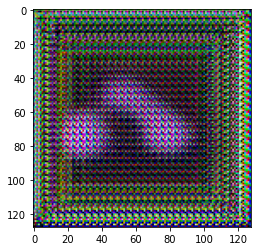

In [15]:
x = g_model_BtoA.predict(animals[:3])
plt.imshow(x[1])

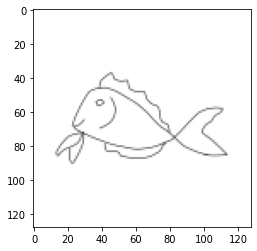

In [17]:
plt.imshow(animals[1])

In [ ]:
# conclusions: too much time!